# Collocate the back trajectories with GFED analysis

Here we read in the HYSPLIT data then we collocate it with the Global Fire Emission Database, that we have pre-processed and saved as .nc files

In [1]:
import s3fs
import xarray as xr
import urllib
import matplotlib.pyplot as plt
import cartopy as cy
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
import numpy as np
from scipy.stats import t
from ease_lonlat import EASE2GRID, SUPPORTED_GRIDS
import pandas as pd
from scipy.stats import linregress
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as ticker
import datetime as dt
import scipy
import itertools
import datetime
import glob
import math
from datetime import datetime, timedelta
import datetime
from datetime import datetime
import re
import matplotlib.pyplot as plt
import pandas as pd
from calendar import monthrange

import sys

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\GitHub\HYSPLIT-processing')
import HYSPLIT_processing as HYprocess
sys.path.append(r'C:\Users\DominicHeslinRees\Documents\GitHub\HYSPLIT_plotting')
import HYSPLIT_plotting as HYplot

%load_ext autoreload
%autoreload 2

In [81]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 36.4 MiB
                           _43: 36.4 MiB
                           _47: 36.4 MiB
                    df_removed: 32.3 MiB
                        df_AHZ: 13.1 MiB
                      df_first:  2.2 MiB
                           _28:  2.2 MiB
                           _30:  2.2 MiB
                           _38: 675.6 KiB
                           _37: 80.5 KiB


In [84]:
del _47

# load hysplit abs data: 

In [2]:
def load_year_of_datetime_trajs(year, inpath="E:\\HYSPLIT\\processed\\", folder='abs', obs_col='obs',
                                select_for_mixed_layer=False, select_for_above_mixed_layer=False,
                                usecols=['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 
                                        'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude'],
                                data_format='.dat'):
    #use the current year
    dict_dtype = dict(zip(['Traj_num', 'grid_lon', 'grid_lat', obs_col,'time_step'], 
                          [np.int8, np.int16, np.int8, np.float16, np.float16]))
    df = HYplot.concat_years(inpath, folder=folder, years=np.arange(year, year+1, 1),
                            index_col=False, parse_dates=True, dict_dtype=dict_dtype,
                            usecols=usecols,
                            select_for_mixed_layer=select_for_mixed_layer, 
                            select_for_above_mixed_layer=select_for_above_mixed_layer, data_format=data_format)
    df['arrival_time'] = pd.to_datetime(df['arrival_time']) #
    df = df.reset_index()
    year_to_df_dict = dict({str(year-1):df[df['DateTime'].dt.year == year-1], 
                          str(year):df[df['DateTime'].dt.year == year]})
    print("year: "+str(year)+" has length: "+str(len(df[df['DateTime'].dt.year == year])))
    #add the backwards part of the next year, if possible
    try:
        print("added the next year:")
        print("year: "+str(year+1))
        df_next= HYplot.concat_years(inpath, folder=folder, years=np.arange(year+1, year+2, 1),
                                      index_col=False, parse_dates=True, dict_dtype=dict_dtype,
                                      usecols=usecols,
                                     select_for_mixed_layer=select_for_mixed_layer, 
                                     select_for_above_mixed_layer=select_for_above_mixed_layer,
                                     data_format=data_format)
        df_next['arrival_time'] = pd.to_datetime(df_next['arrival_time']) #
        df_next = df_next.reset_index()
        print("add: file of length: "+str(len(df_next[df_next['DateTime'].dt.year == year])))        
        year_to_df_dict_next = dict({str(year):df_next[df_next['DateTime'].dt.year == year], 
                              str(year+1):df_next[df_next['DateTime'].dt.year == year+1]})
        df_year = pd.concat([year_to_df_dict[str(year)], year_to_df_dict_next[str(year)]])
        print("year: "+str(year)+" has length: "+str(len(df_year))+" now")
    except:
        print("no extra file")
        df_year = year_to_df_dict[str(year)] #if no extra file
    return df_year

In [3]:
def find_value_lat_lon(lat, lon, traj_datetime):
    array = ds_GFED[var].sel(lat=lat, lon=lon, datetime=traj_datetime, method='nearest').squeeze()
    value = array.values
    return value

def append_var_columnwise(df_trajs, var_name):
    df_trajs = df_trajs.copy()
    df_trajs.loc[:, var_name] = df_trajs[['latitude', 'longitude', 'DateTime']].apply(lambda x: find_value_lat_lon(*x), axis=1)
    df_trajs[var_name] = df_trajs[var_name].astype(float)
    return df_trajs

In [4]:
def append_var_to_df(df_trajs, ds_GFED, var, var_name):
    df_trajs = df_trajs.copy()
    df_trajs.loc[:, var_name] = ds_GFED[var].sel(lat=xr.DataArray(df_trajs['latitude']),
                                           lon=xr.DataArray(df_trajs['longitude']),
                                           datetime=xr.DataArray(df_trajs['DateTime']),
                                           method='nearest')
    df_trajs[var_name] = df_trajs[var_name].astype(float)
    return df_trajs

In [5]:
def select_month_year(ds, year, month):
    ds_month_year = ds.where(((ds['datetime.year'] == year) & (ds['datetime.month'] == month)), drop=True)
    return ds_month_year

# Process: 

## 3 hourly resolution data: 

For the data sets of GFED between 2003 - 2023

In [7]:
years=np.arange(2011, 2024, 1)

months=np.arange(1, 13, 1)
savepath = r'E:\df_trajs_GFED'
HYSPLIT_path = "E:\\HYSPLIT\\processed\\"
nslice = None
var_name='BC_GFED'
var = 'BC'

GFED_path = r'E:\Global_Fire_Emissions_Database\netcdfs'
data_format = '.pickle'

for year in years:
    print("year: "+str(year))
    try:
        del df
    except:
        print("no df")
        pass
    
    months=np.arange(1, 13, 1)
    if year == 2011:
        months=np.arange(2, 13, 1)    
    
    df = load_year_of_datetime_trajs(year, "E:\\HYSPLIT\\processed\\", obs_col='obs',
                                    select_for_mixed_layer=True, select_for_above_mixed_layer=False,
                                    data_format='.pickle')    
   
    print("var name: "+str(var_name))
    for month in months:
        print("month: "+str(month))        
        df_month = df[df['DateTime'].dt.month == month] #take endpoints of that month
        print("Number of endpoints to collocate: "+str(len(df_month)))   
        if len(df_month) > 0:
            month = "{:02d}".format(month) #make 0X
            print('open: \\GFED\\'+str(year)+'\\GFED_'+str(year)+'_'+str(month)+'.nc') 
            try:
                del ds_GFED
            except:
                print("no ds_GFED")
                pass
            
            ds_GFED = xr.open_dataset(GFED_path+'\\BC_'+str(year)+'_'+str(month)+'.nc')
            print(ds_GFED['BC'].mean())
                        
            GFED_year_check = int(ds_GFED.datetime.dt.year.mean().values)    
            print(GFED_year_check)
            GFED_month_check = int(ds_GFED.datetime.dt.month.mean().values)    
            print(GFED_month_check)  
                        
            if (year == GFED_year_check) & (int(month) == GFED_month_check):
                print("yes")                
                if nslice is not None:
                    df_month = df_month.iloc[:nslice,:] 
                
                df_month = append_var_to_df(df_month, ds_GFED, var, var_name)
                
                if data_format == '.pickle':
                    df_month.to_pickle(savepath+'//'+str(year)+'_'+str(month)+'_GFED_ML.pickle')
                    print("saved as: "+str(savepath)+'//'+str(year)+'_'+str(month)+'_GFED_ML.pickle')
                
                if data_format == '.dat':
                    df_month.to_csv(savepath+'//'+str(year)+'_'+str(month)+'_GFED_ML.dat', index=False)
                    print("saved as: "+str(savepath)+'//'+str(year)+'_'+str(month)+'_GFED_ML.dat')

year: 2011
no df
E:\HYSPLIT\processed\abs\dfs\
E:\HYSPLIT\processed\abs\dfs\\2011*.pickle
no years provided, just a year
['E:\\HYSPLIT\\processed\\abs\\dfs\\2011.pickle']
E:\HYSPLIT\processed\abs\dfs\2011.pickle
['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude']
Length before: 46268631
Length after: 40532400
['Traj_num', 'grid_lon', 'grid_lat', 'obs', 'time_step']
altitude of air mass below mixed layer height
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9391641 entries, 2011-01-01 00:00:00 to 2011-11-14 19:00:00
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Traj_num      int8   
 1   time_step     float16
 2   grid_lat      int8   
 3   grid_lon      int16  
 4   obs           float16
 5   arrival_time  object 
 6   RAINFALL      float64
 7   latitude      float64
 8   longitude     float64
dtypes: float16(2), float64(3), int16(1), int8(2), object(1)
m

<xarray.DataArray 'BC' ()>
array(5.79688528e-07)
2012
10
yes
saved as: E:\df_trajs_GFED//2012_10_GFED_ML.pickle
month: 11
Number of endpoints to collocate: 760574
open: \GFED\2012\GFED_2012_11.nc
<xarray.DataArray 'BC' ()>
array(4.08413292e-07)
2012
11
yes
saved as: E:\df_trajs_GFED//2012_11_GFED_ML.pickle
month: 12
Number of endpoints to collocate: 1041374
open: \GFED\2012\GFED_2012_12.nc
<xarray.DataArray 'BC' ()>
array(5.65587108e-07)
2012
12
yes
saved as: E:\df_trajs_GFED//2012_12_GFED_ML.pickle
year: 2013
E:\HYSPLIT\processed\abs\dfs\
E:\HYSPLIT\processed\abs\dfs\\2013*.pickle
no years provided, just a year
['E:\\HYSPLIT\\processed\\abs\\dfs\\2013.pickle']
E:\HYSPLIT\processed\abs\dfs\2013.pickle
['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude']
Length before: 13063515
Length after: 11840202
['Traj_num', 'grid_lon', 'grid_lat', 'obs', 'time_step']
altitude of air mass below mixed layer height
<clas

saved as: E:\df_trajs_GFED//2014_10_GFED_ML.pickle
month: 11
Number of endpoints to collocate: 588926
open: \GFED\2014\GFED_2014_11.nc
<xarray.DataArray 'BC' ()>
array(4.14638726e-07)
2014
11
yes
saved as: E:\df_trajs_GFED//2014_11_GFED_ML.pickle
month: 12
Number of endpoints to collocate: 1466179
open: \GFED\2014\GFED_2014_12.nc
<xarray.DataArray 'BC' ()>
array(5.36721572e-07)
2014
12
yes
saved as: E:\df_trajs_GFED//2014_12_GFED_ML.pickle
year: 2015
E:\HYSPLIT\processed\abs\dfs\
E:\HYSPLIT\processed\abs\dfs\\2015*.pickle
no years provided, just a year
['E:\\HYSPLIT\\processed\\abs\\dfs\\2015.pickle']
E:\HYSPLIT\processed\abs\dfs\2015.pickle
['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude']
Length before: 54795936
Length after: 53138109
['Traj_num', 'grid_lon', 'grid_lat', 'obs', 'time_step']
altitude of air mass below mixed layer height
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16897064 entr

<xarray.DataArray 'BC' ()>
array(8.46546175e-07)
2016
6
yes
saved as: E:\df_trajs_GFED//2016_06_GFED_ML.pickle
month: 7
Number of endpoints to collocate: 1090139
open: \GFED\2016\GFED_2016_07.nc
<xarray.DataArray 'BC' ()>
array(1.58820778e-06)
2016
7
yes
saved as: E:\df_trajs_GFED//2016_07_GFED_ML.pickle
month: 8
Number of endpoints to collocate: 1898478
open: \GFED\2016\GFED_2016_08.nc
<xarray.DataArray 'BC' ()>
array(1.41121648e-06)
2016
8
yes
saved as: E:\df_trajs_GFED//2016_08_GFED_ML.pickle
month: 9
Number of endpoints to collocate: 1615086
open: \GFED\2016\GFED_2016_09.nc
<xarray.DataArray 'BC' ()>
array(1.17595273e-06)
2016
9
yes
saved as: E:\df_trajs_GFED//2016_09_GFED_ML.pickle
month: 10
Number of endpoints to collocate: 2134672
open: \GFED\2016\GFED_2016_10.nc
<xarray.DataArray 'BC' ()>
array(4.88964323e-07)
2016
10
yes
saved as: E:\df_trajs_GFED//2016_10_GFED_ML.pickle
month: 11
Number of endpoints to collocate: 1860498
open: \GFED\2016\GFED_2016_11.nc
<xarray.DataArray 'BC'

Number of endpoints to collocate: 1185034
open: \GFED\2018\GFED_2018_02.nc
<xarray.DataArray 'BC' ()>
array(4.4080862e-07)
2018
2
yes
saved as: E:\df_trajs_GFED//2018_02_GFED_ML.pickle
month: 3
Number of endpoints to collocate: 665385
open: \GFED\2018\GFED_2018_03.nc
<xarray.DataArray 'BC' ()>
array(4.22307542e-07)
2018
3
yes
saved as: E:\df_trajs_GFED//2018_03_GFED_ML.pickle
month: 4
Number of endpoints to collocate: 855905
open: \GFED\2018\GFED_2018_04.nc
<xarray.DataArray 'BC' ()>
array(5.84831347e-07)
2018
4
yes
saved as: E:\df_trajs_GFED//2018_04_GFED_ML.pickle
month: 5
Number of endpoints to collocate: 1382084
open: \GFED\2018\GFED_2018_05.nc
<xarray.DataArray 'BC' ()>
array(5.83794355e-07)
2018
5
yes
saved as: E:\df_trajs_GFED//2018_05_GFED_ML.pickle
month: 6
Number of endpoints to collocate: 1153357
open: \GFED\2018\GFED_2018_06.nc
<xarray.DataArray 'BC' ()>
array(7.25027257e-07)
2018
6
yes
saved as: E:\df_trajs_GFED//2018_06_GFED_ML.pickle
month: 7
Number of endpoints to collo

altitude of air mass below mixed layer height
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11231152 entries, 2021-01-10 18:00:00 to 2021-01-14 09:00:00
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Traj_num      int8   
 1   time_step     float16
 2   grid_lat      int8   
 3   grid_lon      int16  
 4   obs           float16
 5   arrival_time  object 
 6   RAINFALL      float64
 7   latitude      float64
 8   longitude     float64
dtypes: float16(2), float64(3), int16(1), int8(2), object(1)
memory usage: 1.2 GB
size of df: 11231152
add: file of length: 155812
year: 2020 has length: 10646897 now
var name: BC_GFED
month: 1
Number of endpoints to collocate: 611327
open: \GFED\2020\GFED_2020_01.nc
<xarray.DataArray 'BC' ()>
array(8.58432589e-07)
2020
1
yes
saved as: E:\df_trajs_GFED//2020_01_GFED_ML.pickle
month: 2
Number of endpoints to collocate: 745962
open: \GFED\2020\GFED_2020_02.nc
<xarray.DataArray 'BC' ()>
array(6.85185702e-07)


year: 2022 has length: 12637848
added the next year:
year: 2023
E:\HYSPLIT\processed\abs\dfs\
E:\HYSPLIT\processed\abs\dfs\\2023*.pickle
no years provided, just a year
['E:\\HYSPLIT\\processed\\abs\\dfs\\2023.pickle']
E:\HYSPLIT\processed\abs\dfs\2023.pickle
['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude']
Length before: 16515387
Length after: 16133067
['Traj_num', 'grid_lon', 'grid_lat', 'obs', 'time_step']
altitude of air mass below mixed layer height
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3815203 entries, 2023-03-27 05:00:00 to 2023-04-07 08:00:00
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Traj_num      int8   
 1   time_step     float16
 2   grid_lat      int8   
 3   grid_lon      int16  
 4   obs           float16
 5   arrival_time  object 
 6   RAINFALL      float64
 7   latitude      float64
 8   longitude     float64
dtypes: float16

## just monthly data for 2002: 

For 2002, the data sets only have a monthly resolution for the GFED

In [42]:
years=np.arange(2002, 2003, 1) #2002

months=np.arange(1, 13, 1)
savepath = r'E:\df_trajs_GFED'
HYSPLIT_path = "E:\\HYSPLIT\\processed\\"
nslice = None
var_name='BC_GFED'
var = 'BC'

#GFED_path = r'C:\Users\DominicHeslinRees\Documents\Data\Global_Fire_Emissions_Database'
GFED_path = r'E:\Global_Fire_Emissions_Database\netcdfs\monthly'
data_format = '.pickle'

for year in years:
    print("year: "+str(year))
    try:
        del df
    except:
        print("no df")
        pass
    
    df = load_year_of_datetime_trajs(year, "E:\\HYSPLIT\\processed\\", obs_col='obs',
                                    select_for_mixed_layer=True, select_for_above_mixed_layer=False,
                                    data_format='.pickle')    
   
    print("var name: "+str(var_name))
    for month in months:
        print("month: "+str(month))        
        df_month = df[df['DateTime'].dt.month == month] #take endpoints of that month
        print("Number of endpoints to collocate: "+str(len(df_month)))   
        if len(df_month) > 0:
            month = "{:02d}".format(month) #make 0X
        try:
            del ds_GFED
        except:
            print("no ds_GFED")
            pass

        ds_GFED = xr.open_dataset(GFED_path+'\\BC_monthly_'+str(year)+'.nc')        
        ds_GFED = select_month_year(ds_GFED, year, int(month))
        print(ds_GFED['BC'].mean())

        GFED_year_check = int(ds_GFED.datetime.dt.year.mean().values)    
        print(GFED_year_check)

        if (year == GFED_year_check):
            print("yes: correct year")                
            if nslice is not None:
                df_month = df_month.iloc[:nslice,:] 

            df_month = append_var_to_df(df_month, ds_GFED, var, var_name)

            if data_format == '.pickle':
                df_month.to_pickle(savepath+'//'+str(year)+'_'+str(month)+'_GFED_ML.pickle')
                print("saved as: "+str(savepath)+'//'+str(year)+'_'+str(month)+'_GFED_ML.pickle')

            if data_format == '.dat':
                df_month.to_csv(savepath+'//'+str(year)+'_'+str(month)+'_GFED_ML.dat', index=False)
                print("saved as: "+str(savepath)+'//'+str(year)+'_'+str(month)+'_GFED_ML.dat')

year: 2002
no df
E:\HYSPLIT\processed\abs\dfs\
E:\HYSPLIT\processed\abs\dfs\\2002*.pickle
no years provided, just a year
['E:\\HYSPLIT\\processed\\abs\\dfs\\2002.pickle']
E:\HYSPLIT\processed\abs\dfs\2002.pickle
['Traj_num', 'time_step', 'grid_lat', 'grid_lon', 'obs', 'arrival_time', 'MIXDEPTH', 'RAINFALL', 'altitude', 'latitude', 'longitude']
Length before: 38202597
Length after: 33530571
['Traj_num', 'grid_lon', 'grid_lat', 'obs', 'time_step']
altitude of air mass below mixed layer height
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7743164 entries, 2002-03-08 14:00:00 to 2002-11-25 23:00:00
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Traj_num      int8   
 1   time_step     float16
 2   grid_lat      int8   
 3   grid_lon      int16  
 4   obs           float16
 5   arrival_time  object 
 6   RAINFALL      float64
 7   latitude      float64
 8   longitude     float64
dtypes: float16(2), float64(3), int16(1), int8(2), object(1)
m

# Append: 

In [2]:
GFED_path = 'F:\\df_trajs_GFED'

dict_dtypes = {'Traj_num': np.dtype('int8'),
 'time_step': np.dtype('float32'),
 'latitude': np.dtype('float32'),
 'longitude': np.dtype('float32'),
 'altitude': np.dtype('float32'),
 'RAINFALL': np.dtype('float32'),
 'MIXDEPTH': np.dtype('float32'),
 'grid_lon': np.dtype('int32'),
 'grid_lat': np.dtype('int32'),
 'obs': np.dtype('float32'),
 'BC_GFED': np.dtype('float32')}

In [3]:
def read_in_months(GFED_path, year, months, dict_dtypes, data_format='.pickle'):
    DFs = []
    for month in months:
        print("month: "+str(month))
        try:
            month = "{:02d}".format(month) #make 0X
            if data_format == '.dat':
                df_month = pd.read_csv(GFED_path+'\\'+str(year)+'_'+str(month)+'_GFED_ML'+str(data_format),
                                       dtype=dict_dtypes, parse_dates=['DateTime', 'arrival_time'])
            if data_format == '.pickle':                
                df_month = pd.read_pickle(GFED_path+'\\'+str(year)+'_'+str(month)+'_GFED_ML'+str(data_format))
            DFs.append(df_month)
        except:
            pass
    df = pd.concat(DFs)
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    return df

def groupby_divide(df):
    df_groupby = df.groupby('arrival_time').sum()['BC_GFED']
    df_groupby = df_groupby.to_frame()

    df_Traj_num = df.groupby('arrival_time')['Traj_num'].nunique()
    df_Traj_num = df_Traj_num.to_frame()

    df_groupby_ = df_groupby.div(df_Traj_num.values)
    try:
        del df_groupby
        del df_Traj_num
    except:
        pass
    return df_groupby_

def divide_by_number_of_hours(df):
    year = df['DateTime'].dt.year[0]
    if year == 2002:
        df['month'] = df['DateTime'].dt.month
        df['num_of_days'] = df['month'].apply(lambda x: monthrange(year, x)[-1])
        df['num_of_hours'] = df['num_of_days']*24
        df['BC_GFED'] = df['BC_GFED']/df['num_of_hours']
    if year != 2002:
        df['BC_GFED'] = df['BC_GFED']/3 #emissions sapread over 3 hours, but presented on an hourly basis
    return df

In [4]:
def append_files(GFED_path, dict_dtypes):
    DFs = []
    for year in np.arange(2002, 2024, 1):
        print("year: "+str(year))
        df = read_in_months(GFED_path, year, months=np.arange(1,13,1), dict_dtypes=dict_dtypes)
        df = divide_by_number_of_hours(df)
        df = groupby_divide(df)
        DFs.append(df)
    df_years_ = pd.concat(DFs)
    return df_years_

In [5]:
df = append_files(GFED_path, dict_dtypes)

year: 2002
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2003
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2004
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2005
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2006
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2007
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2008
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2009
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11
month: 12
year: 2010
month: 1
mont

In [7]:
# load
df_ = HYplot.load_df(loadpath=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\GFED', filename='GFED')

loading: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\GFED\GFED.dat


In [8]:
def fancy(ax, fontsize=20):    
    # thickning the axes spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=0.5)    
    # mask top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def quick_plot(df_groupby, ms=2, fontsize=12, ymax=0.0002):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,4), sharex=True)
    ax1.plot(df_groupby.index, df_groupby['BC_GFED'], 'o', mfc='None', mec='k', alpha=.8, ms=ms)
    fancy(ax1, fontsize=fontsize)
    ax1.set_ylabel('Sum of BC emissions,\n GFED [g BCm$^{-2}$]', fontsize=12)
    ax1.set_ylim(0, ymax)
    plt.show()

def quick_2plot(df_groupby, df_fire_count, ms=2, fontsize=12):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,12), sharex=True)
    ax1.plot(df_groupby.index, df_groupby['BC_GFED'], 'o', mfc='None', mec='k', alpha=.8, ms=ms)
    fancy(ax1, fontsize=fontsize)

    ax1.set_ylabel('Sum of BC emissions,\n GFED [g BCm$^{-2}$]', fontsize=12)
    ax1.set_ylim(0, 0.02)

    ax2.plot(df_fire_count.index, df_fire_count['fire_count'], 'o', mfc='None', mec='r', alpha=.8, ms=ms)
    ax2.set_xlim(df_groupby.index[0], df_groupby.index[-1])
    ax2.set_ylabel('Active fire count,\n MODIS [-]', fontsize=12)
    ax2.set_ylim(0, 50000)
    fancy(ax2, fontsize=fontsize)
    
    ax3.plot(df_abs637.index, df_abs637['abs637'], 'o', mfc='None', mec='k', alpha=.8, ms=ms)
    ax3.set_xlim(df_abs637.index[0],  df_abs637.index[-1])
    ax3.set_ylabel('$\sigma_{\mathrm{ap}}$ [Mm$^{-1}$]', fontsize=12)
    #ax3.set_ylim(0, 50000)
    fancy(ax3, fontsize=fontsize)
    plt.show()

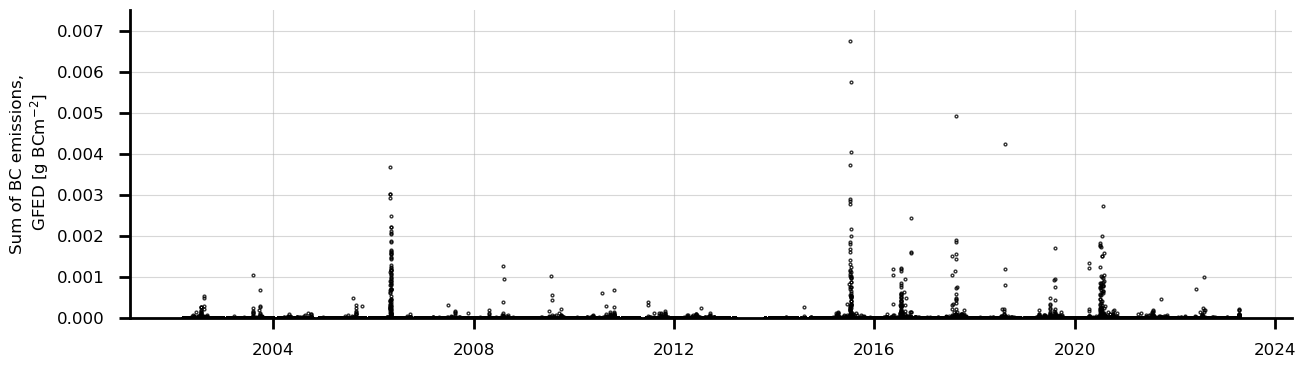

In [9]:
quick_plot(df, ms=2, fontsize=12, ymax=0.0075)

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
import sys

sys.path.append(r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts\Trends')
import trends_functions as fu_trends

In [12]:
df = fu_trends.create_month_season_numbers(df)

Note: the slow build-up season crosses over two years as it goes from October-January, so the year corresponds to previous year
Number of unique seasons: 63
full_season_to_season_num given


In [13]:
df.head(2)

,BC_GFED,month_num,year,season_abb,season_name,season_abb_year,season_ordinal
arrival_time,,,,,,,
2002-03-08 14:00:00,0.0,3,2002,AHZ,Arctic Haze,AHZ_2002,1
2002-03-08 15:00:00,0.0,3,2002,AHZ,Arctic Haze,AHZ_2002,1


In [24]:
def sigfig(value):
    valuesf = float('%.3g' % value)
    return valuesf

def calculate_mean(df, var='BC_GFED', scalar=10**(9)):
    df = df[var].copy()
    print("2002 - 2007")
    mean_2002_2007 = df.loc['2002-01-01 00:00:00': '2007-12-31 23:59:59'].mean()*scalar
    print(sigfig(mean_2002_2007))
    print("2008 - 2012")
    mean_2008_2012 = df.loc['2008-01-01 00:00:00': '2012-12-31 23:59:59'].mean()*scalar
    print(sigfig(mean_2008_2012))
    print("2013 - 2017")
    mean_2013_2017 = df.loc['2013-01-01 00:00:00': '2017-12-31 23:59:59'].mean()*scalar
    print(sigfig(mean_2013_2017))
    print("2018 - 2023")
    mean_2018_2023 = df.loc['2018-01-01 00:00:00': '2023-12-31 23:59:59'].mean()*scalar
    print(sigfig(mean_2018_2023))
    
def for_seasons(df, season, var='BC_GFED', scalar=10**(6)):
    df_season = df[df['season_abb'] == season]
    calculate_mean(df_season, var, scalar)
    
def remove_extreme_event(df, start_remove, end_remove):
    print(len(df))
    df = df.loc[~df.index.isin(df.index[df.index.slice_indexer(start_remove, end_remove)])]
    print(len(df))
    return df

In [25]:
df_removed = remove_extreme_event(df, '2006-04-21', '2006-05-07')

147487
147197


In [26]:
for_seasons(df, season='AHZ')
print("\nextreme removed")
for_seasons(df_removed, season='AHZ')

2002 - 2007
5.78
2008 - 2012
0.21
2013 - 2017
0.688
2018 - 2023
0.635

extreme removed
2002 - 2007
0.2
2008 - 2012
0.21
2013 - 2017
0.688
2018 - 2023
0.635


In [27]:
for_seasons(df, season='SUM')
print("\nextreme removed")
for_seasons(df_removed, season='SUM')

2002 - 2007
1.11
2008 - 2012
1.34
2013 - 2017
14.8
2018 - 2023
5.79

extreme removed
2002 - 2007
1.11
2008 - 2012
1.34
2013 - 2017
14.8
2018 - 2023
5.79


In [28]:
for_seasons(df, season='SBU')
print("\nextreme removed")
for_seasons(df_removed, season='SBU')

2002 - 2007
0.0864
2008 - 2012
0.397
2013 - 2017
0.239
2018 - 2023
0.224

extreme removed
2002 - 2007
0.0864
2008 - 2012
0.397
2013 - 2017
0.239
2018 - 2023
0.224


# Save: 

In [18]:
def remove_duplicates(df):
    print("Length before: "+str(len(df)))
    duplicateRowsDF = df.index[df.index.duplicated()]
    print("Duplicate Rows except first occurrence based on all columns are : "+str(len(duplicateRowsDF)))      
    df_first = df.loc[~df.index.duplicated(keep='first')]
    df_last = df.loc[~df.index.duplicated(keep='last')]
    print("Length after: "+str(len(df_first)))
    print("Length after: "+str(len(df_last)))
    return df_first, df_last

In [27]:
df_first = remove_duplicates(df)[0]

Length before: 147487
Duplicate Rows except first occurrence based on all columns are : 3994
Length after: 143493
Length after: 143493


In [29]:
HYplot.save_df(df_first, path=r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\GFED',                   
                name='GFED')

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\GFED\GFED.dat


In [31]:
df_first.mean()

BC_GFED    0.000002
dtype: float64